In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Dataset

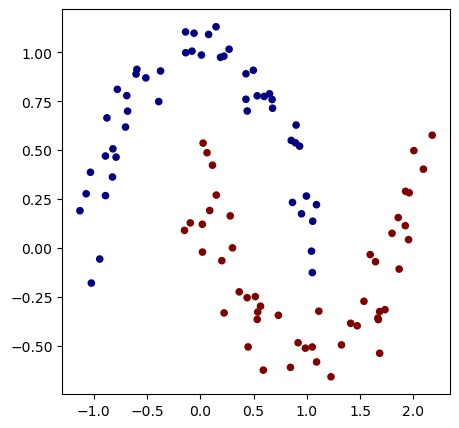

In [39]:
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

# make y be -1 or 1
y = y * 2 - 1

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

## Model

In [40]:
from nn import Value, Neuron, Layer, MLP

model = MLP(2, [16, 16, 1]) 
# Input: 2d, 2 hidden layers (of 16 neurons each), Output: 1d

print("number of parameters", len(model.parameters()))

number of parameters 337


## Loss

In [41]:
def loss(batch_size=None):
    """
    Computes the total loss and accuracy for the model on a batch of data.
    If batch_size is None, uses the full dataset (X, y).
    """
    # --- Prepare minibatch ---
    if batch_size is None:
        batch_x, batch_y = X, y
    else:
        # randomly sample batch_size examples without replacement
        selected_indices = np.random.permutation(X.shape[0])[:batch_size]
        batch_x = X[selected_indices]
        batch_y = y[selected_indices]

    # wrap numerical inputs in Value objects for autograd
    batch_inputs = [
        list(map(Value, x_vector)) for x_vector in batch_x
    ]

    # --- Forward pass: compute model scores ---
    scores = [model(sample) for sample in batch_inputs]

    # --- Data loss: hinge loss for SVM (max-margin) ---
    # for each (y_i, score): loss = max(0, 1 - y * score)
    margin_losses = [
        (Value(1) - y_i * score).relu() for y_i, score in zip(batch_y, scores)
    ]
    average_margin_loss = sum(margin_losses) * (1.0 / len(margin_losses))

    # --- Regularization loss: L2 on all model parameters ---
    l2_lambda = 1e-4
    squared_params = [param * param for param in model.parameters()]
    l2_regularization = l2_lambda * sum(squared_params)

    # total loss = data loss + regularization penalty
    total_loss = average_margin_loss + l2_regularization

    # --- Accuracy calculation ---
    # count correct sign predictions
    is_correct = [
        (y_i > 0) == (score.data > 0) for y_i, score in zip(batch_y, scores)
    ]
    accuracy = sum(is_correct) / len(is_correct)

    return total_loss, accuracy

## Training

In [42]:
epochs = 80
batch_size = 50
for epoch in range(epochs):
    # Forward
    total_loss, acc = loss(batch_size)

    # Backward
    model.zero_grad()
    total_loss.backward()

    # Update (Stochastic Gradient Descent)
    learning_rate = 1.0 - 0.9 * epoch / epochs
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"epoch {epoch}, loss {total_loss.data}, accuracy {acc*100}%")

epoch 0, loss 0.48321078467892925, accuracy 80.0%
epoch 1, loss 0.8120408942277932, accuracy 74.0%
epoch 2, loss 1.235944507947839, accuracy 52.0%
epoch 3, loss 1.007297405979868, accuracy 57.99999999999999%
epoch 4, loss 0.8906526807116754, accuracy 52.0%
epoch 5, loss 0.8408949611267271, accuracy 78.0%
epoch 6, loss 0.43965097187213087, accuracy 78.0%
epoch 7, loss 0.2763536936617088, accuracy 88.0%
epoch 8, loss 0.32516322673781944, accuracy 84.0%
epoch 9, loss 0.2763793953776569, accuracy 84.0%
epoch 10, loss 0.3118672143648052, accuracy 84.0%
epoch 11, loss 0.33431501205995906, accuracy 80.0%
epoch 12, loss 0.336263386807688, accuracy 86.0%
epoch 13, loss 0.323096461537692, accuracy 88.0%
epoch 14, loss 0.19679554402762697, accuracy 90.0%
epoch 15, loss 0.20895401482373613, accuracy 88.0%
epoch 16, loss 0.17096397607975272, accuracy 98.0%
epoch 17, loss 0.14726846866302987, accuracy 96.0%
epoch 18, loss 0.2315971829513407, accuracy 92.0%
epoch 19, loss 0.14826878165557106, accurac

## Visualization

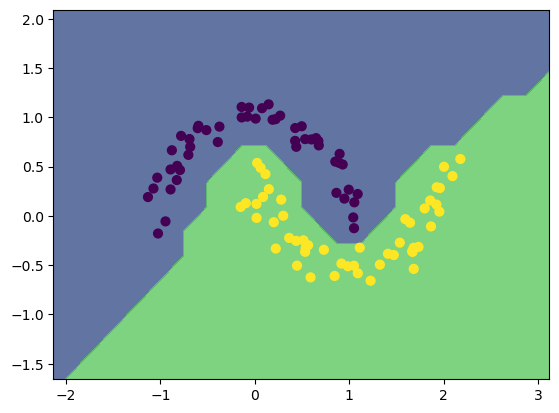

In [43]:
h=0.25

x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

pts = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([
    model([Value(x_), Value(y_)]).data > 0
    for x_, y_ in pts
]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=y, s=40)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()